In [2]:
import sys
sys.path.append("/Users/CC/anaconda/lib/python2.7/site-packages")

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LinearRegression as Lin_Reg

import datetime
import time
%matplotlib inline

## Part 1 - Cleaning Data
by Zainab Doctor

In [3]:
#Read in data
shots = pd.read_csv('shot_logs.csv', delimiter=',')

print 'dimensions of dataset: ', shots.shape
print 'column headers: ', shots.columns.values
shots.head(3)


dimensions of dataset:  (128069, 21)
column headers:  ['GAME_ID' 'MATCHUP' 'LOCATION' 'W' 'FINAL_MARGIN' 'SHOT_NUMBER' 'PERIOD'
 'GAME_CLOCK' 'SHOT_CLOCK' 'DRIBBLES' 'TOUCH_TIME' 'SHOT_DIST' 'PTS_TYPE'
 'SHOT_RESULT' 'CLOSEST_DEFENDER' 'CLOSEST_DEFENDER_PLAYER_ID'
 'CLOSE_DEF_DIST' 'FGM' 'PTS' 'player_name' 'player_id']


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148


In [4]:
subset = ['GAME_ID', 'LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 
          'SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'player_id']

data = shots[subset]
print data.shape

(128069, 13)


In [5]:
data = data[data['SHOT_CLOCK'].notnull()] #lose 5567 entries

data = data[data['SHOT_CLOCK'] > 1] #results in loss of 1004 shots taken with <1 second on the shot clock

#data = data[data['GAME_CLOCK'] != '0:00'] filtering based on GAME_CLOCK doesn't result in any further loss of entries

#Convert game clock to seconds
T = data['GAME_CLOCK'].values
gameclock_seconds = []

for i in range(T.shape[0]):
    x = T[i].split(':')
    gameclock_seconds.append(60*int(x[0]) + int(x[1]))

data['GAME_CLOCK'] = gameclock_seconds

data = data[data['GAME_CLOCK'] > 1] # results in loss of 2 entries

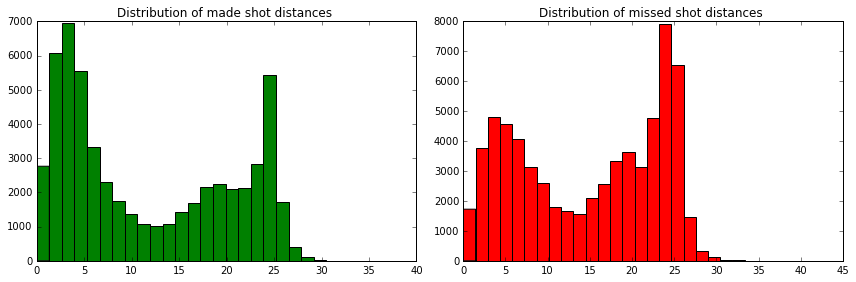

In [6]:
#Plotting shot distances based on whether they were made or missed
made = data[data['SHOT_RESULT'] == 'made']
missed = data[data['SHOT_RESULT'] == 'missed']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(made['SHOT_DIST'], 30, color='green')
ax1.set_title('Distribution of made shot distances ')

ax2.hist(missed['SHOT_DIST'],30, color='red')
ax2.set_title('Distribution of missed shot distances ')

plt.tight_layout()    
plt.show()

## Explore the data:
### Shots Taken by Players
by Hubert Huang

In [7]:
### Data Exploration
# There are actually data from 281 players
print 'Number of unique player ID:', np.unique(data['player_id'].values).shape[0]
player_id = np.unique(data['player_id'].values)

# How many unique games are there?
# Several players may share the same game ID (becuase they all played that night)
print 'Number of unique game ID:', np.unique(data['GAME_ID'].values).shape[0]


# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])

# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])
    
    
# name_id links player_id and player_name
# Created a unique player_name vs player_id table
name_id = shots[['player_name', 'player_id']]
# print name_id.shape # Sanity check
_, idx = np.unique(name_id['player_id'], return_index=True)
name_id = name_id.loc[idx]
# print name_id.shape # Sanity check

Number of unique player ID: 281
Number of unique game ID: 896


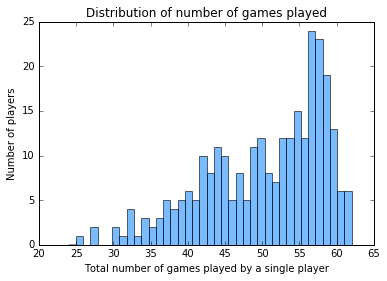

In [8]:
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.6)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

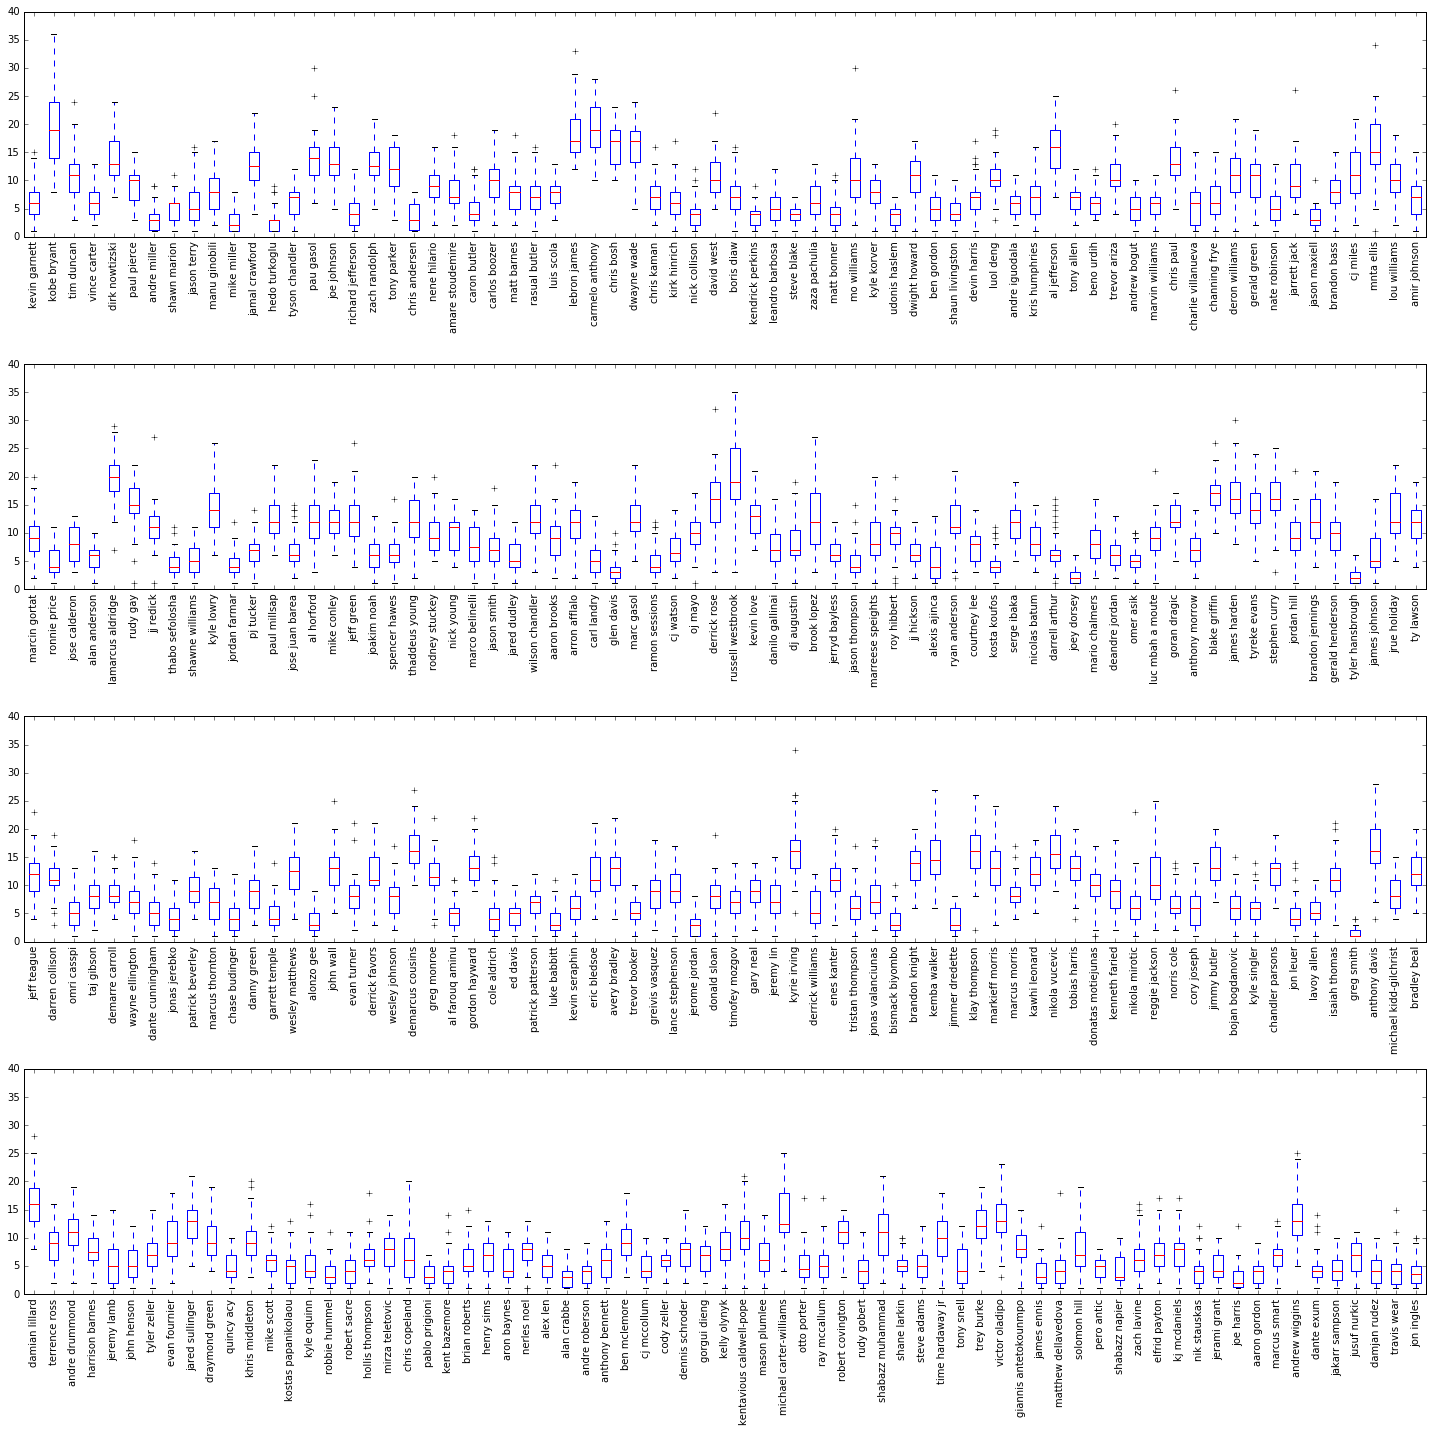

In [9]:
# Plot the range of number of shots taken by each player in their every game
fig, ax = plt.subplots(4,1,figsize=(20,20))
ax[0].boxplot([shots_by_player[pid] for pid in player_id[:70]])
ax[0].set_ylim((0,40))
ax[0].set_xticklabels([name_id['player_name'][name_id['player_id'] == pid].values[0] 
                      for pid in player_id[:70]], rotation='vertical')

ax[1].boxplot([shots_by_player[pid] for pid in player_id[70:140]])
ax[1].set_ylim((0,40))
ax[1].set_xticklabels([name_id['player_name'][name_id['player_id'] == pid].values[0] 
                       for pid in player_id[70:140]], rotation='vertical')

ax[2].boxplot([shots_by_player[pid] for pid in player_id[140:210]])
ax[2].set_ylim((0,40))
ax[2].set_xticklabels([name_id['player_name'][name_id['player_id'] == pid].values[0]
                       for pid in player_id[140:210]], rotation='vertical')

ax[3].boxplot([shots_by_player[pid] for pid in player_id[210:]])
ax[3].set_ylim((0,40))
ax[3].set_xticklabels([name_id['player_name'][name_id['player_id'] == pid].values[0]
                       for pid in player_id[210:]], rotation='vertical')

plt.tight_layout()
plt.show()

How many unique shot series do we have?  14165


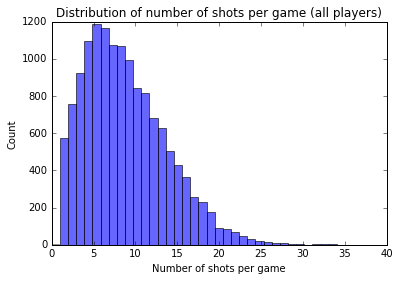

Shoot series with length smaller than 4 comprises: 15.9% of all shot series


In [10]:
# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (6,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.6)

ax.set_title('Distribution of number of shots per game (all players)')
ax.set_xlabel('Number of shots per game')
ax.set_ylabel('Count')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [11]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]]
                                  [np.where(gameID_by_player[data['player_id'].iloc[i]] == data['GAME_ID'].iloc[i])]) 
                              for i in range(data.shape[0])]

# Now filter out all the shot series shorter than 4
print data.shape[0]

data = data[data['shot_series_length'] > 4]
print data.shape[0] #results in loss of 10k or so shots

### Sanity check
#data.iloc[:100]

121172
111945


number of unique player ID: 280


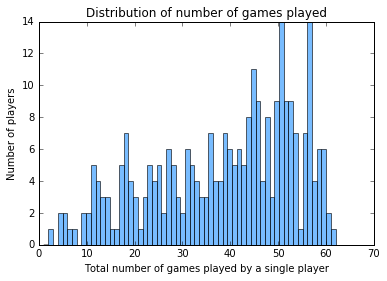

In [12]:
# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.6)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

## Conditional probability
To answer if Hot Hand Theory is true or not based on our data, we first replicated the work that was done by Gilovich, Vallone and Tsersky (1985), looking at the conditional probability of making a hit after hit(s) or miss(es). Assumining shots were chosen randomly, the probability of making a hit after a hit streak should be higher than the probability of making a hit after a miss streak, if Hot Hand Theory is true.

$$P(hit|hit(s)) > P(hit|miss(es))$$

We selected the top 5 player for analysis because they scored high, played in more games within the season, and shot more per game. This allows more series and longer series per player for the analysis.

In [13]:
top5_player_id = [2544, 201939, 201566, 2546, 202691]

### Making sure that the top five players make sense
print 'The top five players are:'
for player_id in top5_player_id:
    print '{}: {:s}'.format(player_id, name_id['player_name'][name_id['player_id'] == player_id].values[0])

The top five players are:
2544: lebron james
201939: stephen curry
201566: russell westbrook
2546: carmelo anthony
202691: klay thompson


In [14]:
# HTH
# Subset the data dataframe to contain only the top 5 players
print data.shape
data_top5 = data[(data['player_id'] == 2544) |
                 (data['player_id'] == 201939) |
                 (data['player_id'] == 201566) |
                 (data['player_id'] == 2546) |
                 (data['player_id'] == 202691)]
data_top5 = data_top5.reset_index(drop=True)
print data_top5.shape

# Create 3 columns to store the streat metrics
data_top5.loc[:, 'serie_id'] = np.nan # Each player has his set if serie_id starting from 1
data_top5.loc[:, 'MAKE_STREAK'] = np.nan # Number of cumulative shots made, 0 if miss
data_top5.loc[:, 'MISS_STREAK'] = np.nan # Number of cumulative shots missed, 0 if make
data_top5.loc[:, 'streak_metric'] = np.nan # MAKE_STREAK - MISS_STREAK
print data_top5.shape

# data_top5[:5] # Check

(111945, 14)
(4489, 14)
(4489, 18)


In [15]:
#### Fill in the streak metrics

# To keep track whether we are within the same game of the same player
p = data_top5.loc[0, 'player_id']
g = data_top5.loc[0, 'GAME_ID']

# Tracker
serie = 0

for index, row in data_top5.iterrows():
    if (p == row['player_id']) & (g == row['GAME_ID']):
        data_top5.loc[index, 'serie_id'] = serie
    elif (p == row['player_id']) & (g != row['GAME_ID']):
        g = row['GAME_ID']
        serie += 1
        data_top5.loc[index, 'serie_id'] = serie 
    elif (p != row['player_id']) & (g == row['GAME_ID']):
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie
    else:
        g = row['GAME_ID']
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie

# Tracker
hit_count = 0
miss_count = 0
serie = data_top5.loc[0, 'serie_id']

for index, row in data_top5.iterrows():
    if serie == row['serie_id']:
        if row['SHOT_RESULT'] == 'made':
            hit_count += 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count += 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
    else:
        serie = row['serie_id']
        
        if row['SHOT_RESULT'] == 'made':
            hit_count = 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count = 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count

# data_top5[:950] # Check

In [16]:
## Function:
## conditional_probability
    ## Input: p (player_id; only the top5 player id accepted)
## Calculate the field goal percentage of player with player_id

def conditional_probability(p):
    data_temp1 = data_top5[data_top5['player_id'] == p].reset_index(drop=True)

    hit_count = (data_temp1['MISS_STREAK'] == 0).sum()
    miss_count = (data_temp1['MAKE_STREAK'] == 0).sum()

#     print 'Player {} made {} shots in {} series'.format(p, data_temp1.shape[0], int(data_temp1['serie_id'].max()+1))

    # Tracker
    hit_hit1 = 0; miss_hit1 = 0; hit_miss1 = 0; miss_miss1 = 0
    hit_hit2 = 0; miss_hit2 = 0; hit_miss2 = 0; miss_miss2 = 0
    hit_hit3 = 0; miss_hit3 = 0; hit_miss3 = 0; miss_miss3 = 0
    serie = data_temp1.loc[0, 'serie_id']

    for serie in range(int(data_temp1['serie_id'].max() + 1)):
        df_temp = data_temp1[data_temp1['serie_id'] == serie].reset_index(drop=True)

        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] > 1):
                hit_hit1 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit1 += 1
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss1 += 1
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] < -1):
                miss_miss1 += 1
        
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] > 2):
                hit_hit2 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit2 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss2 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] < -2):
                miss_miss2 += 1
                
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] > 3):
                hit_hit3 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit3 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss3 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] < -3):
                miss_miss3 += 1

#     print 'P(hit|hit1) = {:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))
#     print 'P(hit|miss1) = {:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))
    
#     print 'P(hit|hit2) = {:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))
#     print 'P(hit|miss2) = {:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))

#     print 'P(hit|hit3) = {:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))
#     print 'P(hit|miss3) = {:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))

    d = {'player_name': [name_id['player_name'][name_id['player_id'] == p].values[0]],
         'P(hit|hit1)': ['{:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))],
         'P(hit|miss1)': ['{:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))],
         'P(hit|hit2)': ['{:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))],
         'P(hit|miss2)': ['{:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))],
         'P(hit|hit3)': ['{:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))],
         'P(hit|miss3)': ['{:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))],
         'P(hit)': ['{:.3f} ({})'.format(hit_count * 1. / (hit_count + miss_count), (hit_count + miss_count))]
        }

    df_temp2 = pd.DataFrame(d)
    return df_temp2

In [17]:
cols = ['player_name', 'P(hit|miss3)', 'P(hit|miss2)', 'P(hit|miss1)', 'P(hit)', 'P(hit|hit1)', 'P(hit|hit2)', 'P(hit|hit3)']
df_conditional = pd.DataFrame()

for p in top5_player_id:
    df_temp = conditional_probability(p)
    df_conditional = df_conditional.append(df_temp)
    
df_conditional[cols]

,player_name,P(hit|miss3),P(hit|miss2),P(hit|miss1),P(hit),P(hit|hit1),P(hit|hit2),P(hit|hit3)
0,lebron james,0.481 (81),0.554 (193),0.527 (440),0.497 (933),0.471 (442),0.445 (200),0.430 (86)
0,stephen curry,0.521 (73),0.548 (186),0.536 (440),0.495 (935),0.452 (438),0.434 (189),0.385 (78)
0,russell westbrook,0.418 (134),0.430 (251),0.459 (495),0.443 (937),0.421 (397),0.357 (157),0.333 (51)
0,carmelo anthony,0.576 (85),0.521 (190),0.471 (384),0.446 (737),0.410 (315),0.377 (122),0.422 (45)
0,klay thompson,0.495 (107),0.463 (227),0.470 (470),0.467 (947),0.469 (420),0.457 (186),0.418 (79)


For all top 5 players, the probabilities of making a hit after a hit streak (length 1-3) were lower than making a hit after a miss streak (length 1-3). Therefore, we observed no sign of hot hand for these top 5 players.

However, the connection between "hot hand" and a higher P(hit) conditioned on previous streak status is only true if each shot was chosen randomly from a pool of shots with varying difficulties. In real life, it is possible that as a player heats up, the defense gets tighter or the player starts making riskier shots as he feels more confident, both of which would mask the effect of "hot-hand". As a result, we consider modeling for the difficulty of each shot, and take the shot difficulty into account.

To account for shot difficulty, we used a strategy similar to what was previously described in Bocskocsky, Ezekowitz, and Stein (2014). Here, a linear regression model was trained using predictors including location, player, defender, shot distance, denfer distance and some time variables, to predict the probability of each shot being made.

The predicted P(hit) serves as a proxy for shot difficulty, which is used to calculate adjusted conditional probability. An analogy to how the adjusted probability is calculated is similar to correcting an unfair coin. For example, consider an unfair coin which shows head 30% of the time and tail 70% of the time. If for this coin, every time a head appears, I count it as 0.7 and if tail appears, 0.3, the adjusted expected value of getting a head or a tail would be around 0.5, as if the coin is fair.

In [18]:
# Because P(hit) does not have a linear relationship with SHOT_DIST
# We turn SHOT_DIST into 30 categorical groups of distances.
data['SHOT_DIST_BIN'] = pd.cut(data['SHOT_DIST'], 30)
print data.shape

# Build the dataframe needed for predicting P(hit)
# Encode categorical values with dummy variables
print 'Column names: ', data.columns.values

encoded_data = pd.DataFrame({})
categorical = ['LOCATION', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_id', 'SHOT_DIST_BIN']
continuous = ['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

for column in data.columns.values:
    if column in categorical:
        encoding = pd.get_dummies(data[column])
        encoded_data = pd.concat([encoded_data, encoding], axis = 1)
    elif column in continuous:
        encoded_data = pd.concat([encoded_data, data[column]], axis = 1)
        

print 'The shape of the encoded dataframe is', encoded_data.shape

# Turn the dataframe into a numpy array
# Predictor variables stored in X, and stadardized to X_std
X = encoded_data.as_matrix(columns=encoded_data.columns)
X_std = preprocessing.scale(X, axis=0)
print 'The shape of the predictor variables is', X_std.shape

# Response variable is stored in y
y = data['FGM']
print 'The shape of the response variable is', y.shape

(111945, 15)
Column names:  ['GAME_ID' 'LOCATION' 'SHOT_NUMBER' 'PERIOD' 'GAME_CLOCK' 'SHOT_CLOCK'
 'SHOT_DIST' 'SHOT_RESULT' 'CLOSEST_DEFENDER_PLAYER_ID' 'CLOSE_DEF_DIST'
 'FGM' 'PTS' 'player_id' 'shot_series_length' 'SHOT_DIST_BIN']
The shape of the encoded dataframe is (111945, 790)
The shape of the predictor variables is (111945, 790)
The shape of the response variable is (111945,)


In [19]:
# Linear regression
linreg = Lin_Reg()
linreg.fit(X_std, y)
print linreg.score(X_std, y)
y_predict = linreg.predict(X_std)

# Modify the predicted values to actual probability values
y_predict = np.array([0.999 if y_pred >= 1 else y_pred for y_pred in y_predict])
y_predict = np.array([0.001 if y_pred <= 0 else y_pred for y_pred in y_predict])
print 'The highest probability of P(hit) is:', y_predict.max()
print 'The lowest probability of P(hit) is:', y_predict.min()

0.0674189042177
The highest probability of P(hit) is: 0.999
The lowest probability of P(hit) is: 0.001


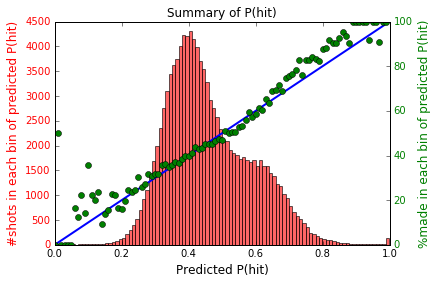

In [20]:
data['P'] = y_predict

p_range = np.arange(0, 100, 1)
p_average = np.array([])

for p in np.arange(0, 1, 0.01):
    p_average = np.append(p_average, data['FGM'][(data['P'] >= p) & (data['P'] < p + 0.01)].values.mean())

p_average = p_average * 100

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.set_title('Summary of P(hit)', fontsize = 12)

ax.hist(y_predict, bins = 100, color = 'r', alpha = 0.6)
ax.set_ylabel('#shots in each bin of predicted P(hit)', color='r', fontsize = 12)
ax.set_xlabel('Predicted P(hit)', fontsize = 12)
for tl in ax.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax.twinx()
ax2.plot(np.arange(0, 1, 0.01), p_range, linewidth = 2)
ax2.plot(np.arange(0, 1, 0.01), p_average, 'o', c = 'g')
ax2.set_ylabel('%made in each bin of predicted P(hit)', color='g', fontsize = 12)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.savefig('Hubert_Fig1.png')

To visualize the predicted P(hit), we binned all shots whose values are within the same hundreth increment of the predicted P(hit). Then, the actual P(hit) was calculated based on the hit and miss statuses of all shots within the same bin. As the figure shows, the predicted P(hit) between 0.2 to 0.8 agrees really well with the acutal hit percentage. Since the majority of shots fall within this range, we believe the predicted P(hit) the mojority of our data is reliable.

In [21]:
# Update data_top5 to contain column 'P'
data_top5['P'] = data[(data['player_id'] == 2544) |
                      (data['player_id'] == 201939) |
                      (data['player_id'] == 201566) |
                      (data['player_id'] == 2546) |
                      (data['player_id'] == 202691)]['P'].values

# Create data_temp1 for adjusted hit/miss values
data_temp1 = data_top5[data_top5['player_id'] == 2544].reset_index(drop=True)
hits = data_temp1['P'][data_temp1['MISS_STREAK'] == 0].values
misses = data_temp1['P'][data_temp1['MAKE_STREAK'] == 0].values
adjusted_hits = sum([1 / p for p in hits])
adjusted_misses = [1 / (1 - p) for p in misses]

In [22]:
## HTH
## Calculate the field goal percentage of player with player_id
def adjusted_conditional_probability(p):
    data_temp1 = data_top5[data_top5['player_id'] == p].reset_index(drop=True)

    hits = data_temp1['P'][data_temp1['MISS_STREAK'] == 0].values
    misses = data_temp1['P'][data_temp1['MAKE_STREAK'] == 0].values
    adjusted_hits = sum([1 / prob for prob in hits])
    adjusted_misses = sum([1 / (1 - prob) for prob in misses])
    
#     print 'Player {} made {} shots in {} series'.format(p, data_temp1.shape[0], int(data_temp1['serie_id'].max()+1))

    # Tracker
    hit_hit1 = 0; miss_hit1 = 0; hit_miss1 = 0; miss_miss1 = 0
    hit_hit2 = 0; miss_hit2 = 0; hit_miss2 = 0; miss_miss2 = 0
    hit_hit3 = 0; miss_hit3 = 0; hit_miss3 = 0; miss_miss3 = 0
    serie = data_temp1.loc[0, 'serie_id']

    for serie in range(int(data_temp1['serie_id'].max() + 1)):
        df_temp = data_temp1[data_temp1['serie_id'] == serie].reset_index(drop=True)

        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] > 1):
                hit_hit1 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit1 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss1 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] < -1):
                miss_miss1 += (1 / (1 - df_temp.loc[r+1, 'P']))
        
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] > 2):
                hit_hit2 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit2 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss2 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] < -2):
                miss_miss2 += (1 / (1 - df_temp.loc[r+1, 'P']))
                
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] > 3):
                hit_hit3 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit3 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss3 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] < -3):
                miss_miss3 += (1 / (1 - df_temp.loc[r+1, 'P']))

#     print 'P(hit|hit1) = {:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))
#     print 'P(hit|miss1) = {:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))
    
#     print 'P(hit|hit2) = {:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))
#     print 'P(hit|miss2) = {:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))

#     print 'P(hit|hit3) = {:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))
#     print 'P(hit|miss3) = {:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))

    d = {'player_name': [name_id['player_name'][name_id['player_id'] == p].values[0]],
         'P(hit|hit1)': ['{:.3f}'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1))],
         'P(hit|miss1)': ['{:.3f}'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1))],
         'P(hit|hit2)': ['{:.3f}'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2))],
         'P(hit|miss2)': ['{:.3f}'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2))],
         'P(hit|hit3)': ['{:.3f}'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3))],
         'P(hit|miss3)': ['{:.3f}'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3))],
         'P(hit)': ['{:.3f}'.format(adjusted_hits * 1. / (adjusted_hits + adjusted_misses))]
        }

    df_temp2 = pd.DataFrame(d)
    return df_temp2

In [23]:
cols = ['player_name', 'P(hit|miss3)', 'P(hit|miss2)', 'P(hit|miss1)', 'P(hit)', 'P(hit|hit1)', 'P(hit|hit2)', 'P(hit|hit3)']
df_conditional = pd.DataFrame()

for p in top5_player_id:
    df_temp = adjusted_conditional_probability(p)
    df_conditional = df_conditional.append(df_temp)
    
df_conditional[cols]

,player_name,P(hit|miss3),P(hit|miss2),P(hit|miss1),P(hit),P(hit|hit1),P(hit|hit2),P(hit|hit3)
0,lebron james,0.500,0.562,0.532,0.507,0.490,0.472,0.430
0,stephen curry,0.553,0.556,0.540,0.501,0.459,0.452,0.395
0,russell westbrook,0.477,0.491,0.512,0.504,0.494,0.426,0.414
0,carmelo anthony,0.614,0.569,0.513,0.504,0.482,0.454,0.506
0,klay thompson,0.533,0.495,0.501,0.503,0.511,0.506,0.470


After shot difficulty correction, as expected, P(hit) of most players are around 0.5.

However, most of the top 5 players still don't show hot hand based on these adjusted conditional probablities. Interesting, Klay Thompson, who recently scored 60 points within 29 minutes shows signs of hot hand when the probability is conditioned on one hit and two hits, in comparison with one miss and two misses. 

For future direction, we would like to explore more players and also collect for more data on players like Klay Thompson, as it is possible that Hot Hand is more porminent on certain players than others. We also need to figure out if the 1% difference of the conditioned P(hit) for Thompson is significant or not.